In [1]:
# Load the modules
import os, sys, logging
import boto3
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

### This notebook shows how to access the Ridgecrest DAS data on AWS and also provide some basic processing and visualization of the data.

#### Setup the AWS SCEDC bucket information

In [2]:
boto3.set_stream_logger('boto3', logging.INFO)
s3 = boto3.resource('s3')
bucket = s3.Bucket('scedc-pds')
s3.meta.client.head_bucket(Bucket='scedc-pds')

{'ResponseMetadata': {'RequestId': 'K08SD3RWP4PF5TWF',
  'HostId': 'bCkuf9ee6Vj4rimTT9QSlZoryQC/r0Amhgflizfw0wfHw44RJDcsv6Pv4RU7ayCi3UqgpkCtSUg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'bCkuf9ee6Vj4rimTT9QSlZoryQC/r0Amhgflizfw0wfHw44RJDcsv6Pv4RU7ayCi3UqgpkCtSUg=',
   'x-amz-request-id': 'K08SD3RWP4PF5TWF',
   'date': 'Mon, 15 Aug 2022 22:10:04 GMT',
   'x-amz-bucket-region': 'us-west-2',
   'x-amz-access-point-alias': 'false',
   'content-type': 'application/xml',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}

### One month (2020/06/23 - 2020/07/29, ~4TB) of Ridgecrest DAS hourly data (250 Hz sampling rate) are currently on AWS. 

### We will look at the file 2020062417.segy, which contains an M5.8 events (ID: 39493944; 2020/06/24T17:40:49, lat = 36.4468, lon= -117.9752, dep = 4.66km)


In [3]:
# The key of the M5.8 earthquake
keys = ['Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy']
file_names = ['/Ridgecrest_DAS/SEG-Y/hourly/2020062417.segy']

# A CSV file including the DAS channel information
das_channel_key = 'Ridgecrest_DAS/das_info.csv'
das_channel_file_names = '/Ridgecrest_DAS/das_info.csv'

### Next you can either move to your own AWS S3 bucket (Option 1) or download to your own local machine (Option 2) for further processing  

### Option 1. Move the data to your own AWS S3 bucket (recommanded if you are familiar with AWS)

In [ ]:
# Creating Session With Boto3.
session = boto3.Session(
aws_access_key_id = 'Your Access Key ID', # replace with your Access Key ID
aws_secret_access_key = 'You Secret access key' # replace with your Secret access key
)

# Creating S3 Resource From the Session.
s3 = session.resource('s3')

# Target bucket where you are going to move the data to
bucket = s3.Bucket('your target bucket name') # replace with your target bucket name

# First move the DAS channel information to your S3 bucket
copy_source = {
    'Bucket': 'scedc-pds',
    'Key': das_channel_key
}
bucket.copy(copy_source, das_channel_key)
# Printing the Information That the File Is Copied.
print('DAS channel info file copied')

# Then move the DAS data file to your S3 bucket
for index in np.arange(len(keys)):
    #Create a Soucre Dictionary That Specifies Bucket Name and Key Name of the Object to Be Copied
    copy_source = {
        'Bucket': 'scedc-pds',
        'Key': keys[index]
    }
    bucket.copy(copy_source, keys[index])

# Printing the Information That the File Is Copied.
print('Single File is copied')

### Option 2. Download the DAS file to the local machine

In [4]:
# Make a directory to store the downloaded DAS data
download_dir = 'directory to store the downloaded DAS data' 
download_dir = '/kuafu/yinjx/AWS_Ridgecrest/download_test/'
# Make the directory to put the downloaded data
data_dir = download_dir

print(data_dir+'/Ridgecrest_DAS')
try:
    os.mkdir(data_dir+'/Ridgecrest_DAS')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir+'/Ridgecrest_DAS')

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
print(data_dir)

try:
    os.mkdir(data_dir+'/Ridgecrest_DAS/SEG-Y/hourly')
except OSError:
    print ("*Creation of the directory %s failed" % data_dir)
else:
    print ("Successfully created the directory %s " % data_dir)
    
print('Downloaded data will be stored here:',data_dir)


# Download the DAS channel info file
bucket.download_file(das_channel_key,data_dir + '/Ridgecrest_DAS/das_info.csv')


# Download the DAS data
for index in np.arange(len(keys)):
    key=keys[index]; file_name=file_names[index]
    file_path = data_dir+file_name
    bucket.download_file(key,file_path)

/kuafu/yinjx/AWS_Ridgecrest/download_test//Ridgecrest_DAS
*Creation of the directory /kuafu/yinjx/AWS_Ridgecrest/download_test/ failed
/kuafu/yinjx/AWS_Ridgecrest/download_test//Ridgecrest_DAS
*Creation of the directory /kuafu/yinjx/AWS_Ridgecrest/download_test/ failed
/kuafu/yinjx/AWS_Ridgecrest/download_test/
*Creation of the directory /kuafu/yinjx/AWS_Ridgecrest/download_test/ failed
Downloaded data will be stored here: /kuafu/yinjx/AWS_Ridgecrest/download_test/


### Load the downloaded data and visualize (example is following the Option 2 on local machine, but can also be easliy modified for AWS)

#### Functions used to load and plot the hourly DAS data

In [5]:
# Function to load the DAS data
def read_PASSCAL_segy(infile, nTraces=1250, nSample=900000, TraceOff=0):
    """Function to read PASSCAL segy raw data
    For Ridgecrest data, there are 1250 channels in total,
    Sampling rate is 250 Hz so for one hour data: 250 * 3600 samples
    """
    fs = nSample/ 3600 # sampling rate
    data = np.zeros((nTraces, nSample), dtype=np.float32)
    gzFile = False
    if infile.split(".")[-1] == "segy":
        fid = open(infile, 'rb')
    elif infile.split(".")[-1] == "gz":
        gzFile = True
        fid = gzip.open(infile, 'rb')
    fid.seek(3600)
    # Skipping traces if necessary
    fid.seek(TraceOff*(240+nSample*4),1)
    # Looping over traces
    for ii in range(nTraces):
        fid.seek(240, 1)
        if gzFile:
            # np.fromfile does not work on gzip file
            BinDataBuffer = fid.read(nSample*4) # read binary bytes from file
            data[ii, :] = struct.unpack_from(">"+('f')*nSample, BinDataBuffer)
        else:
            data[ii, :] = np.fromfile(fid, dtype=np.float32, count=nSample)
    fid.close()

    # Convert the phase-shift to strain (in nanostrain)
    Ridgecrest_conversion_factor = 1550.12 / (0.78 * 4 * np.pi * 1.46 * 8)
    data = data * Ridgecrest_conversion_factor

    das_time = np.arange(0, data.shape[1]) * 1 / fs

    return data, das_time

#TODO: add downsample functions
def donwsample_das(data, das_time, fd=100):
    """
    Down sample das data to fd Hz
    data, das_time_downsampled = donwsample_das(data, das_time, fd=100)
    """
    das_dt_ds = 1/fd
    das_time_downsampled = np.arange(0, das_time[-1], das_dt_ds)

    downsample_f = interp1d(das_time, data, axis=1, bounds_error=False, fill_value=0)
    data = downsample_f(das_time_downsampled)
    return data, das_time_downsampled

# plot the DAS data
def show_data(data, das_time, pclip=99.5):
    fig, ax1 = plt.subplots(figsize=(8,4))
    clipVal = np.percentile(np.absolute(data), pclip)
    ax1.imshow(data.T, 
                extent=[0, data.shape[0], das_time[-1], das_time[0]],
                aspect='auto', vmin=-clipVal, vmax=clipVal, cmap=plt.get_cmap('seismic'))

    ax1.set_xlabel("Channel number")
    ax1.set_ylabel("Time [s]")
    ax1.grid()
    return fig, ax1

#### First load the information about the DAS array

In [6]:
# Load the DAS info file, a Pandas modules can greatly simply this step
temp = np.genfromtxt(data_dir + '/Ridgecrest_DAS/das_info.csv', delimiter=',', skip_header=1)
channel_index = temp[:, 0].astype('int') # Index of good channels
channel_lat = temp[:, 1] # channel latitude
channel_lon = temp[:, 2] # channel longitude

#### Then load the downloaded DAS data, data unit is nano strain

In [7]:
data, das_time = read_PASSCAL_segy(file_path) # Data shape: n_channel x n_samples, data unit is nano strain
dt = das_time[1] - das_time[0]
strain = data[channel_index, :] # Only keep the good channels (bad channels are those at fiber loops and recorded no signals)
# Data is in [num_channels, num_time_samples]
print(strain.shape)

In [9]:
# Downsample the data
strain, das_time = donwsample_das(strain, das_time, fd=100)
print(strain.shape)

(1150, 360000)


Text(0.5, 1.0, 'Raw Strain')

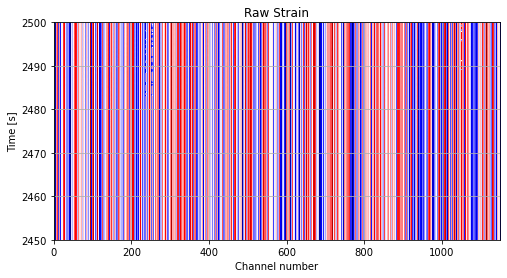

In [10]:
# Show how the raw data looks
fig, ax1 = show_data(strain[:, ::20], das_time, pclip=98)
ax1.set_ylim(2450, 2500)
ax1.set_title('Raw Strain')

#### High pass filter is often needed to remove the low frequency signals in the DAS data to show earthquake signals

In [11]:
from scipy.signal import butter, sosfiltfilt

sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)

Text(0.5, 1.0, 'High-passed Strain')

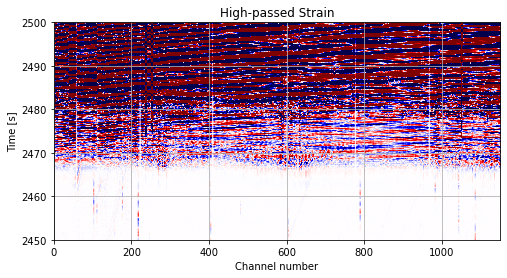

In [12]:
fig, ax2 = show_data(strain_filt[:, ::20], das_time, pclip=98)
ax2.set_ylim(2450, 2500)
ax2.set_title('High-passed Strain')

#### Directly convert the raw strain to strain rate is another way to show the earthquake signal

Text(0.5, 1.0, 'Strain rate')

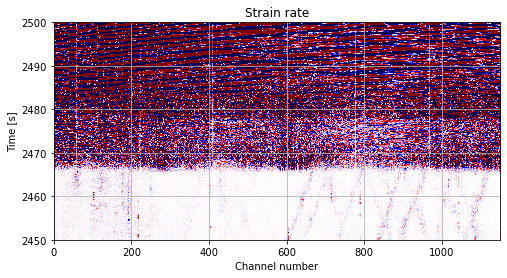

In [13]:
strain_rate = np.diff(strain, axis=1)
strain_rate_time = das_time[:-1] + dt/2

fig, ax3 = show_data(strain_rate[:, ::20], strain_rate_time, pclip=98)
ax3.set_ylim(2450, 2500)
ax3.set_title('Strain rate')

Text(0.5, 1.0, 'Strain rate')

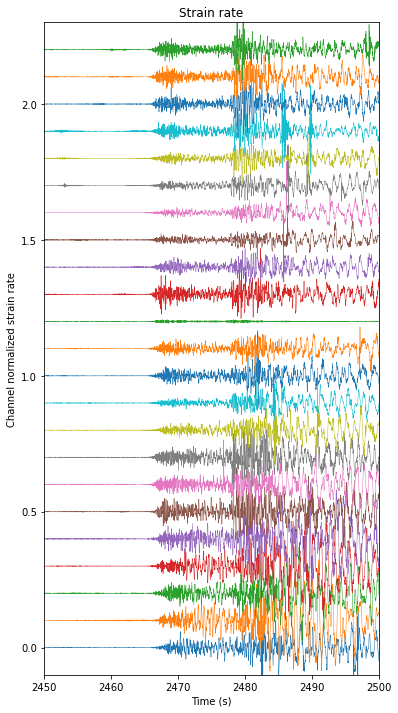

In [14]:
# Show data in time series
clipVal = np.percentile(np.absolute(strain_rate_time), 98)
strain_rate1 = strain_rate/clipVal
fig, ax = plt.subplots(figsize=(6, 12))
for i in range(0, 1150, 50):
    ax.plot(strain_rate_time, strain_rate1[i, :] + i/500, linewidth=0.5)

ax.set_ylim(-0.1, 2.3)
ax.set_xlim(2450, 2500)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channel normalized strain rate')
ax.set_title('Strain rate')
